# 0.0 Libraries

In [88]:
import pandas as pd
import inflection
import math
import calendar
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime

# 1.0 Data

## 1.1 Functions

## 1.2 Loading Data

In [89]:
#raw data
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#joinning/merge
df_store_sales = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [90]:
df_store_sales.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
662176,652,5,2013-11-15,5656,627,1,0,0,0,a,a,20390.0,NaN,NaN,0,NaN,NaN,NaN
987943,839,7,2013-01-27,0,0,0,0,0,0,c,a,240.0,1.0,2015.0,0,NaN,NaN,NaN
6493,919,7,2015-07-26,0,0,0,0,0,0,a,a,2620.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
923664,115,1,2013-03-25,6574,516,1,1,0,1,d,c,5740.0,4.0,2007.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
126954,960,4,2015-04-09,4526,417,1,0,0,1,d,a,8990.0,NaN,NaN,1,31.0,2009.0,"Feb,May,Aug,Nov"


## 1.3 Data Overview

### 1.3.1 Renaming Columns

In [91]:
df1 = df_store_sales.copy()

In [92]:
cols_old = list(df_store_sales.columns)
snakecase = lambda x: inflection.underscore(x)
#new col names
cols_new = list(map(snakecase, cols_old))
cols_new

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

In [93]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.3.2 Data Dimensions


In [94]:
print('# of rows: {}'.format(df1.shape[0]))
print('# of columns: {}'.format(df1.shape[1]))

# of rows: 1017209
# of columns: 18


### 1.3.3 Data Types

In [95]:
# changing Date from object to date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3.4 Checking NA's

In [96]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.3.5 Filling NA's thinking about the business

In [97]:
df1['competition_distance'].max()

75860.0

In [98]:
# CompetitionDistance - no competition nearby or distance is so high we can ignore it            
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)



In [99]:
# CompetitionOpenSinceMonth - no competition or we don't know the date
# I'm using the same value as the column date to fill this NA (first iteration)    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )



In [100]:
# CompetitionOpenSinceYear     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )



In [101]:
# Promo2SinceWeek - NA = stopped promo  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)



In [102]:
# Promo2SinceYear    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



In [103]:
# PromoInterval - shows the months promo was active
month_map = {}
for m in range(1,13):
    month_map[m] = str(calendar.month_name[m])[0:3] 

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        

In [104]:
df1.sample(5).T

,709956,693932,752046,983152,863991
store,487,73,207,508,652
day_of_week,4,4,1,4,6
date,2013-10-03 00:00:00,2013-10-17 00:00:00,2013-08-26 00:00:00,2013-01-31 00:00:00,2013-05-18 00:00:00
sales,0,3196,17064,5431,4424
customers,0,403,1728,534,517
open,0,1,1,1,1
promo,0,0,1,0,0
state_holiday,a,0,0,0,0
school_holiday,0,1,0,0,0
store_type,d,a,a,a,a


In [105]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.3.6 Checking data types after df manipulation

In [106]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [107]:
#promo2_since_week and year are floats and can be changed to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [108]:
#competition_since_month and year are floats and can be changed to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

In [109]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.3.7 Descriptive Statistics

In [110]:
#grouping columns - numerical and categorical
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.3.7.1 Numerical Attributes

In [111]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skw, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenating dataframes
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() #metrics

In [112]:
m.columns = ['attributes', 'min', 'max', 'range', 'neab', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,neab,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


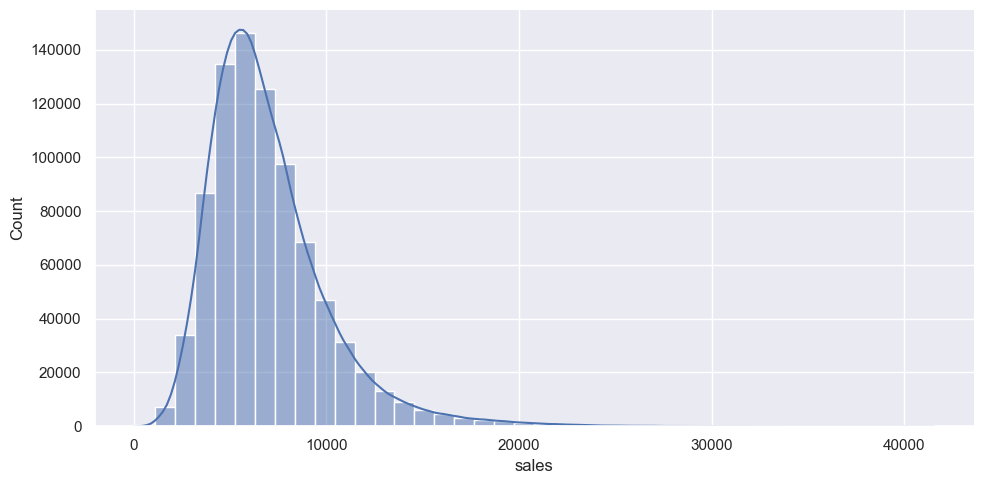

In [113]:
sns.set_theme()
df2 = df1[df1['sales']!=0]
sns.displot(df2['sales'], kde=True, height=5, aspect=2, bins=40);



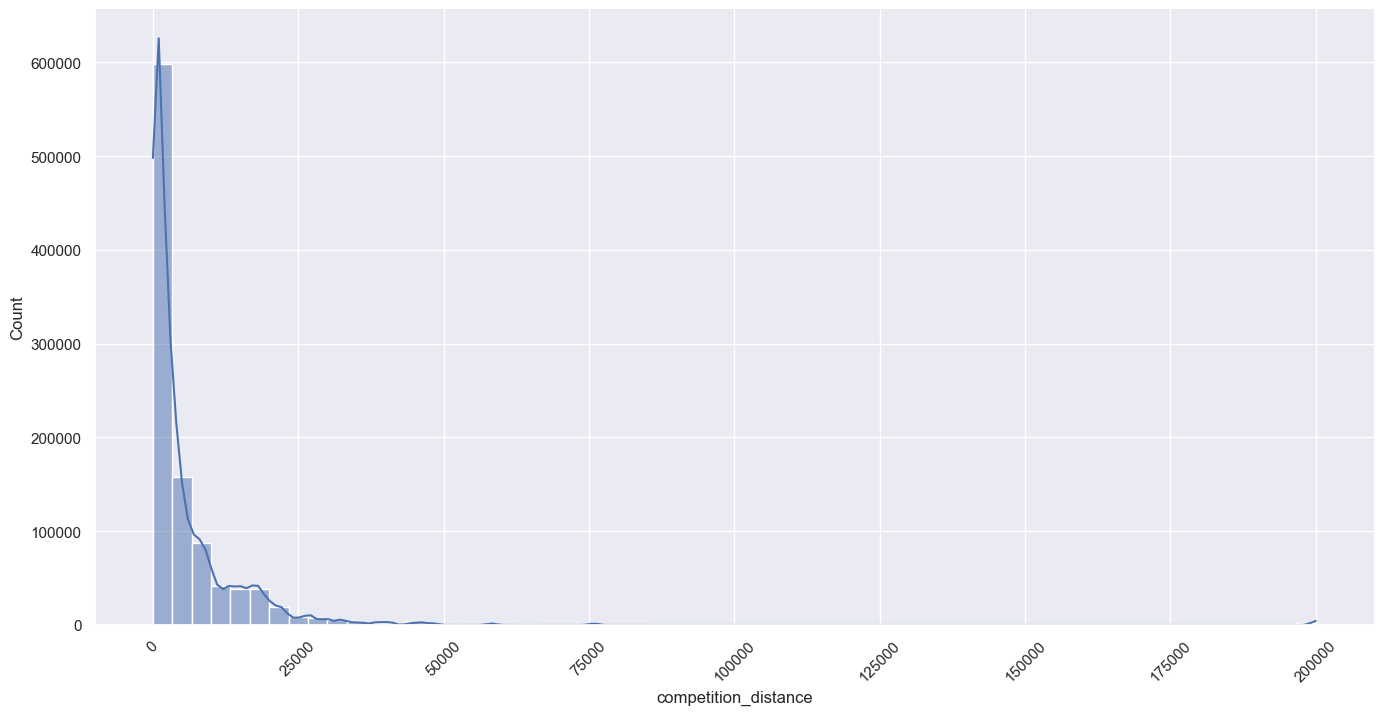

In [114]:
sns.displot(df1['competition_distance'], kde=True, bins=60, height=7, aspect=2)
plt.xticks(rotation=45);

#### 1.3.7.2 Categorical Attributes

In [115]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

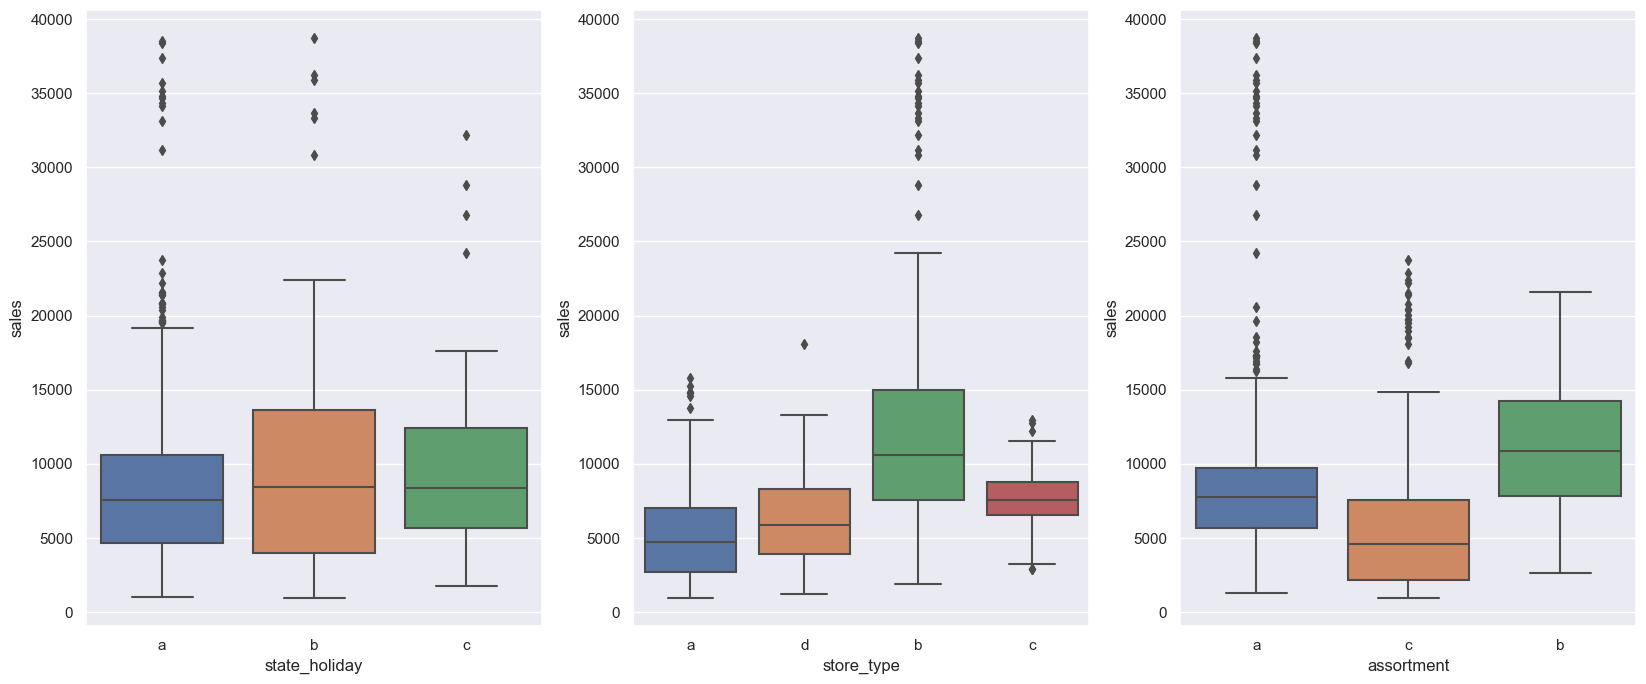

In [116]:
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.boxplot(aux1, x='state_holiday', y='sales')
plt.subplot(1,3,2)
sns.boxplot(aux1, x='store_type', y='sales')
plt.subplot(1,3,3)
sns.boxplot(aux1, x='assortment', y='sales');

# 2.0 Feature Engineering

In [117]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

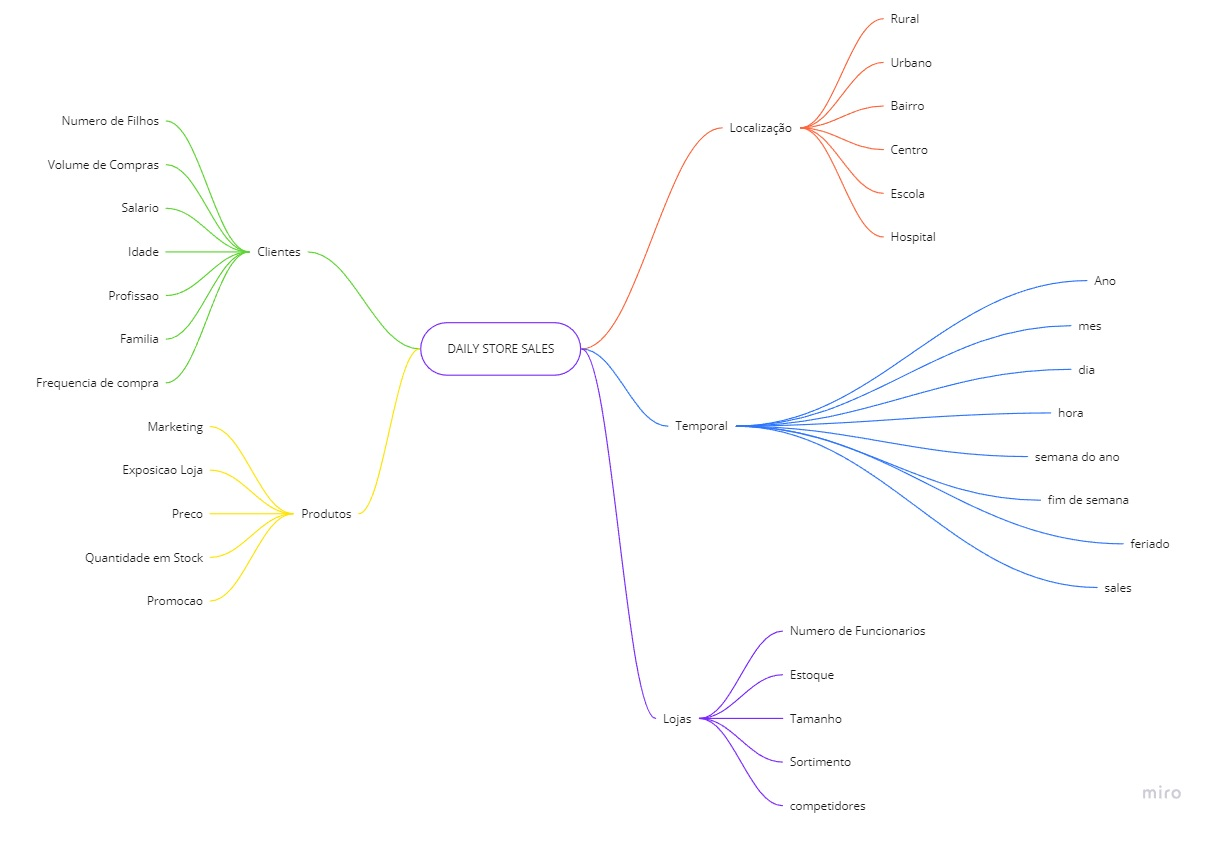

In [118]:
#mindmap coggle/miro
Image('img/mind_map.jpg')

## 2.2 Hypothesis lists

In [119]:
#hipoteses - relacionar cada atributo com a variável resposta (daily sales) para encontar uma correlação

### 2.2.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.\
**2.** Lojas com maior estoque deveriam vender mais.\
**3.** Lojas com maior porte deveriam vender mais.\
**4.** Lojas com maior sortimento deveriam vender mais.\
**5.** Lojas com competidores mais próximos deveriam vender menos.\
**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Product Hypothesis

**1.** Lojas que investem mais me marketing deveriam vender mais.\
**2.** Lojas com maior exposição dos produtos deveriam vender mais.\
**3.** Lojas que tem preços menores nos produtos deveriam vender mais.\
**4.** Lojas com promoções mais agressivas deveriam vender mais.\
**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.\
**6.** Lojas com mais dias de promoção deveriam vender mais.\
**7.** Lojas com mais promoções consecutivas deveriam vender mais.\

### 2.2.3 Time Hypothesis

**1.** Lojas baertas durante o feriado de Natal deveriam vender mais.\
**2.** Lojas deveriam vender mais ao longo dos anos.\
**3.** Lojas deveriam vender mais no segundo semestre do ano.\
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.\
**5.** Lojas deveriam vender menos aos finais de semana.\
**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Hypothesis list

In [120]:
#priorizar as hipoteses que vão ser utilizadas na analise exploratoria
#escolher as hipoteses que já temos os dados primeiro

**1.** Lojas com maior sortimento deveriam vender mais.\
**2.** Lojas com competidores mais próximos deveriam vender menos.\
**3.** Lojas com competidores à mais tempo deveriam vender mais.\
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.\
**5.** Lojas com mais dias de promoção deveriam vender mais.\
**6.** Lojas com mais promoções consecutivas deveriam vender mais.\
**7.** Lojas baertas durante o feriado de Natal deveriam vender mais.\
**8.** Lojas deveriam vender mais ao longo dos anos.\
**9.** Lojas deveriam vender mais no segundo semestre do ano.\
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.\
**11.** Lojas deveriam vender menos aos finais de semana.\
**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [121]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [122]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_months'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

In [123]:
# promo since - without month and day, join week and year to get a date
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + "-1", '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_weeks'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

In [124]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [125]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

In [126]:
df2.sample(5).T

,474558,804831,8190,166309,304035
store,354,587,386,175,398
day_of_week,5,3,5,3,1
date,2014-05-02 00:00:00,2013-07-10 00:00:00,2015-07-24 00:00:00,2015-03-04 00:00:00,2014-10-20 00:00:00
sales,12059,7691,5582,6037,7174
customers,958,552,489,625,711
open,1,1,1,1,1
promo,1,0,0,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,1,1,1
store_type,d,d,d,c,c


# 3.0 Filtering Variables

In [127]:
df3 = df2.copy()

In [128]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week,year_week,competition_since,competition_time_months,promo_since,promo_time_weeks
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtering Lines

In [129]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

## 3.2 Selecting Columns

In [130]:
#ignorar coluna customers - nós não temos o valor das próximas semanas para usar nesa predição
#para isso preciso de um projeto com predição de curtomers e utilizar o resultado com input nesse

#removendo colunas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [131]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week', 'year_week', 'competition_since',
       'competition_time_months', 'promo_since', 'promo_time_weeks'],
      dtype='object')

# 4.0 EDA - Exploratory Data Analysis

In [132]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable 

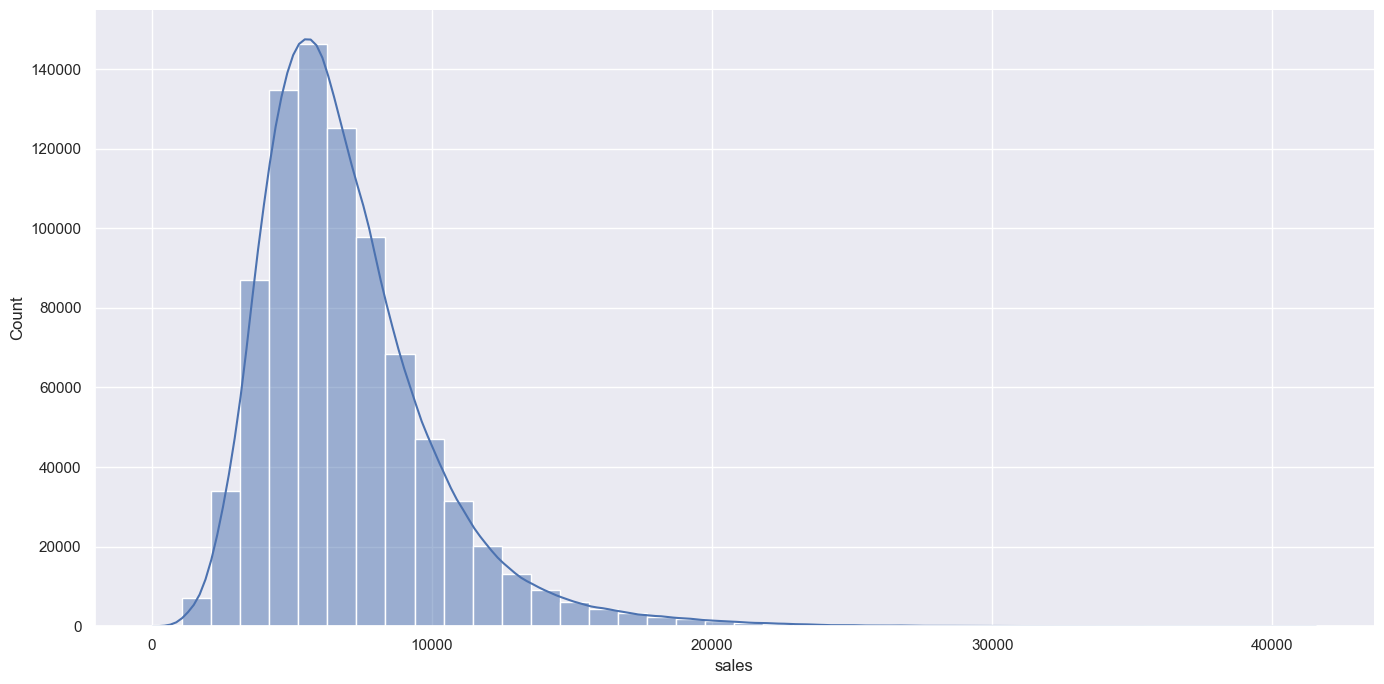

In [133]:
sns.displot(df4['sales'], bins=40, kde=True, height=7, aspect=2);

### 4.1.2 Numeric Variable 

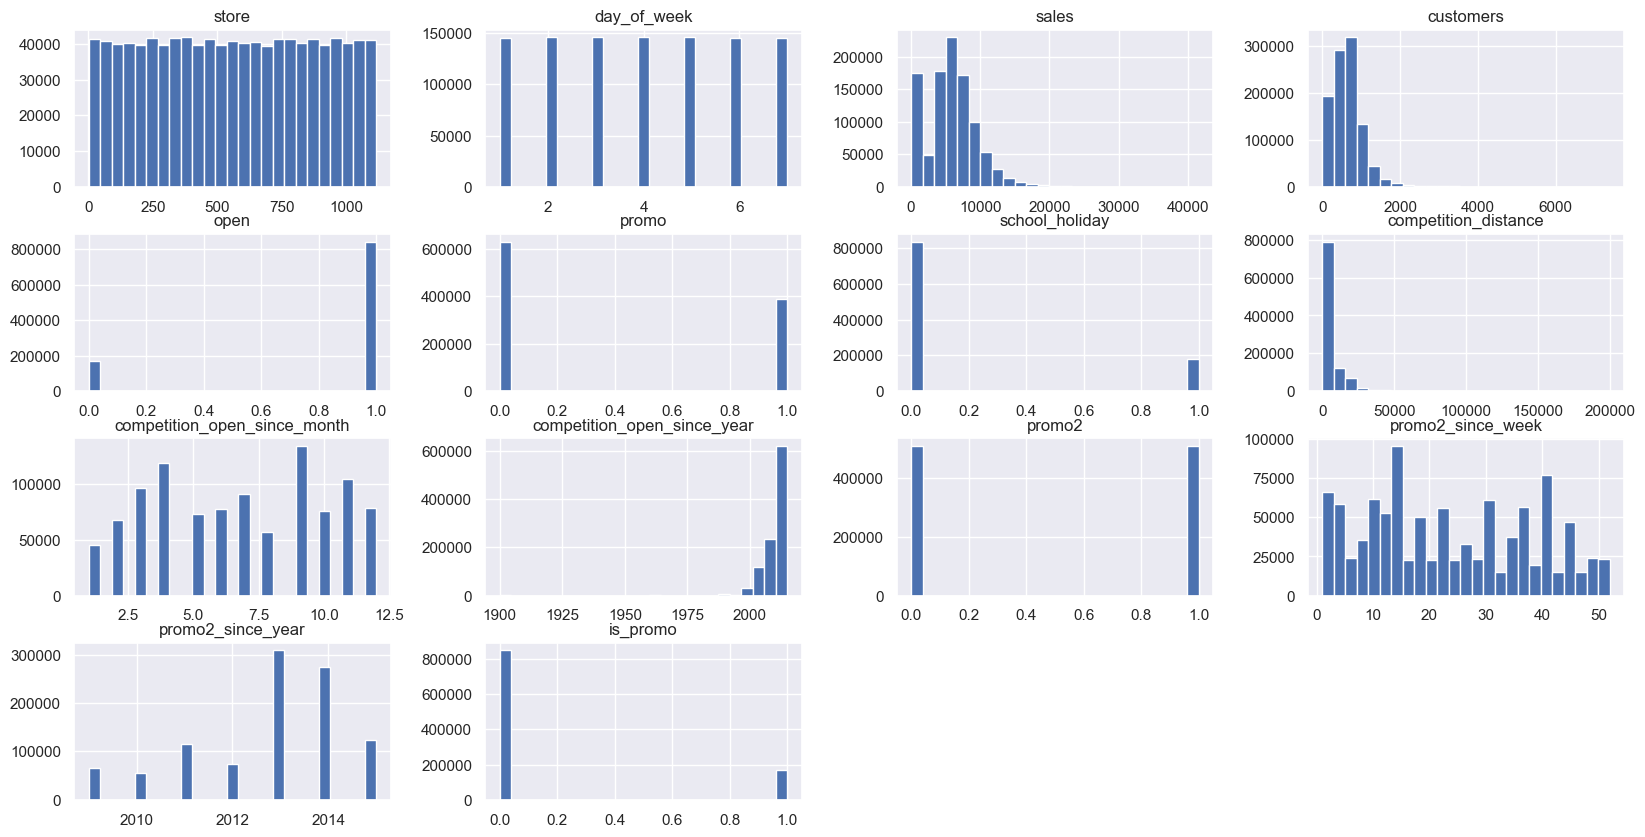

In [134]:
num_attributes.hist(bins=25, figsize=(20,10));

### 4.1.3 Categorical Variable 

In [135]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


<Axes: xlabel='state_holiday', ylabel='count'>

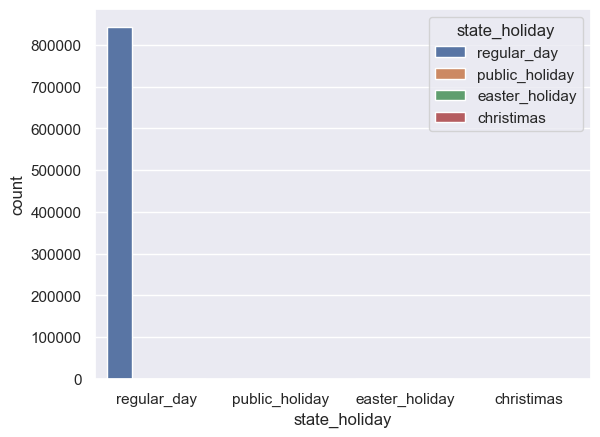

In [207]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

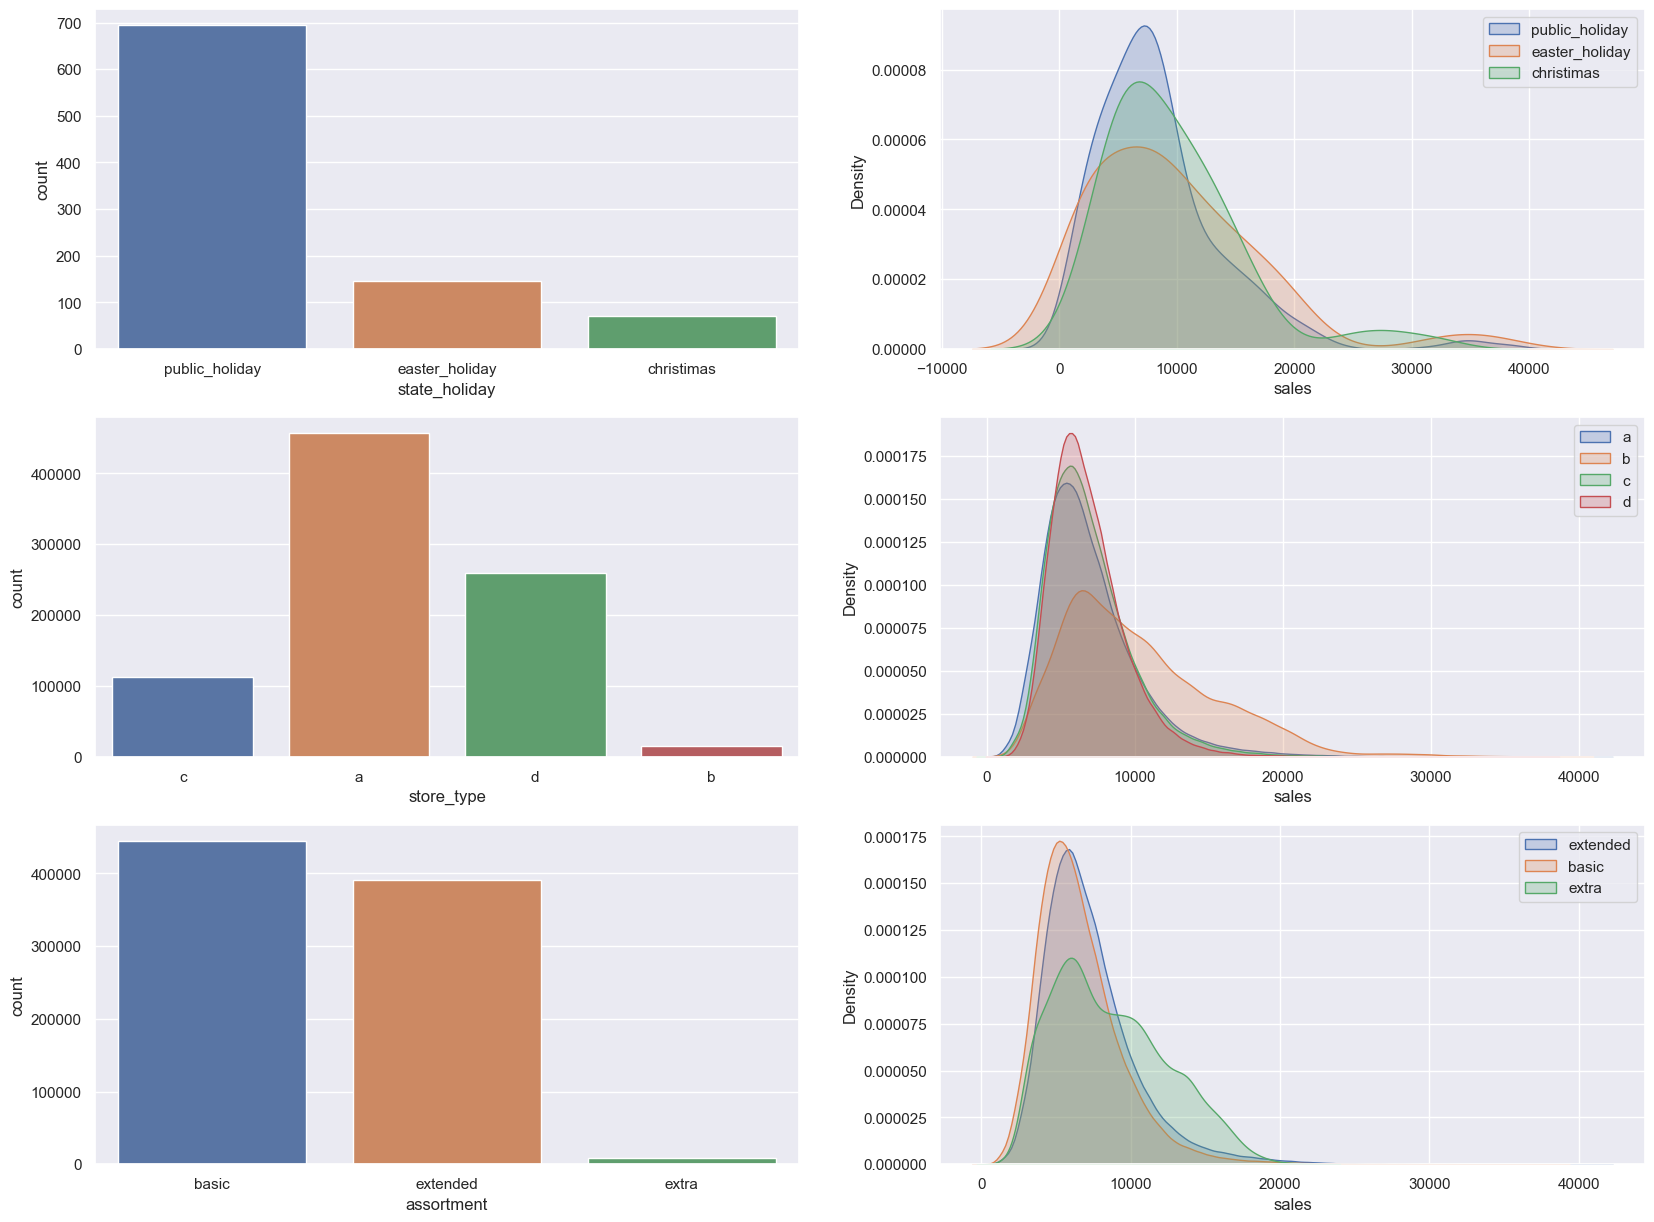

In [211]:
#state_holiday
plt.figure(figsize=(20,15))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a, x='state_holiday');

plt.subplot(3, 2, 2)
# sns.kdeplot(a, x='sales', hue='state_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday'], x='sales', fill=True, label='public_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday'], x='sales', fill=True, label='easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christimas'], x='sales', fill=True, label='christimas')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4, x='store_type');

plt.subplot(3, 2, 4)
# sns.kdeplot(df4, x='sales', hue='store_type', hue_order=['a','b', 'c', 'd'],fill=True);
sns.kdeplot(df4[df4['store_type'] == 'a'], x='sales', fill=True, label='a')
sns.kdeplot(df4[df4['store_type'] == 'b'], x='sales', fill=True, label='b')
sns.kdeplot(df4[df4['store_type'] == 'c'], x='sales', fill=True, label='c')
sns.kdeplot(df4[df4['store_type'] == 'd'], x='sales', fill=True, label='d')
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4, x='assortment');

plt.subplot(3, 2, 6)
# sns.kdeplot(df4, x='sales', hue='assortment',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended'], x='sales', fill=True, label='extended')
sns.kdeplot(df4[df4['assortment'] == 'basic'], x='sales', fill=True, label='basic')
sns.kdeplot(df4[df4['assortment'] == 'extra'], x='sales', fill=True, label='extra')
plt.legend()

plt.show();


## 4.2 Bivariate Analysis

## 4.3 Multivariate Analysis